In [1]:
import IPython.display
import numpy as np
import os
import sys

import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from utils.log_progress import *
from utils.tools import *
from utils.config import *
from utils.utils import *

from unet.unet import *
from unet.data_generator import *

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

### untrained Model:

In [3]:
encoder_type = "vgg19"
unet = UNet()
unet.create_pretrained_model(encoder_type=encoder_type,batchnorm=False,coord_conv=False,input_shape=(512, 768, 3))
model = unet.get_model()
unet.freeze_encoder(model,encoder_type)
model = unet.get_model()

### load Model:

In [30]:
from unet.losses import bce_dice_loss, dice_coeff, iou
from keras.models import load_model, model_from_json
from segmentation_models.losses import bce_jaccard_loss, dice_loss
from segmentation_models.metrics import iou_score

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/vgg19_normalized_80_20/unet_vgg19_norm_80_20.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff,'iou':iou,"bce_jaccard_loss":bce_jaccard_loss})

/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [31]:
def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.layers
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)
    
def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))

In [32]:
display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
d10/kernel:0,"(3, 3, 3, 64)",-0.6557,+0.5534,+0.1917
d10/bias:0,"(64,)",-0.0115,+0.0365,+0.0105
d11/kernel:0,"(3, 3, 64, 64)",-0.2157,+0.2631,+0.0420
d11/bias:0,"(64,)",-0.9560,+0.7619,+0.3038
d20/kernel:0,"(3, 3, 64, 128)",-0.3415,+0.4224,+0.0309
d20/bias:0,"(128,)",-0.1732,+0.3509,+0.1160
d21/kernel:0,"(3, 3, 128, 128)",-0.1917,+0.2455,+0.0231
d21/bias:0,"(128,)",-0.5372,+0.6120,+0.1812
d30/kernel:0,"(3, 3, 128, 256)",-0.1756,+0.5894,+0.0175
d30/bias:0,"(256,)",-0.1762,+0.2301,+0.0649


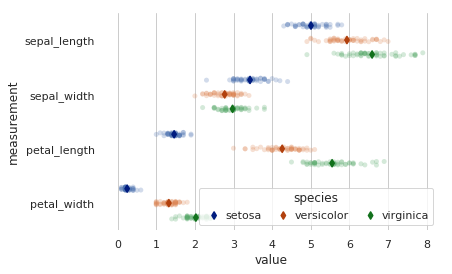

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
iris = sns.load_dataset("iris")

# "Melt" the dataset to "long-form" or "tidy" representation
iris = pd.melt(iris, "species", var_name="measurement")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="value", y="measurement", hue="species",
              data=iris, dodge=True, jitter=True,
              alpha=.25, zorder=1)

# Show the conditional means
sns.pointplot(x="value", y="measurement", hue="species",
              data=iris, dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="species",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

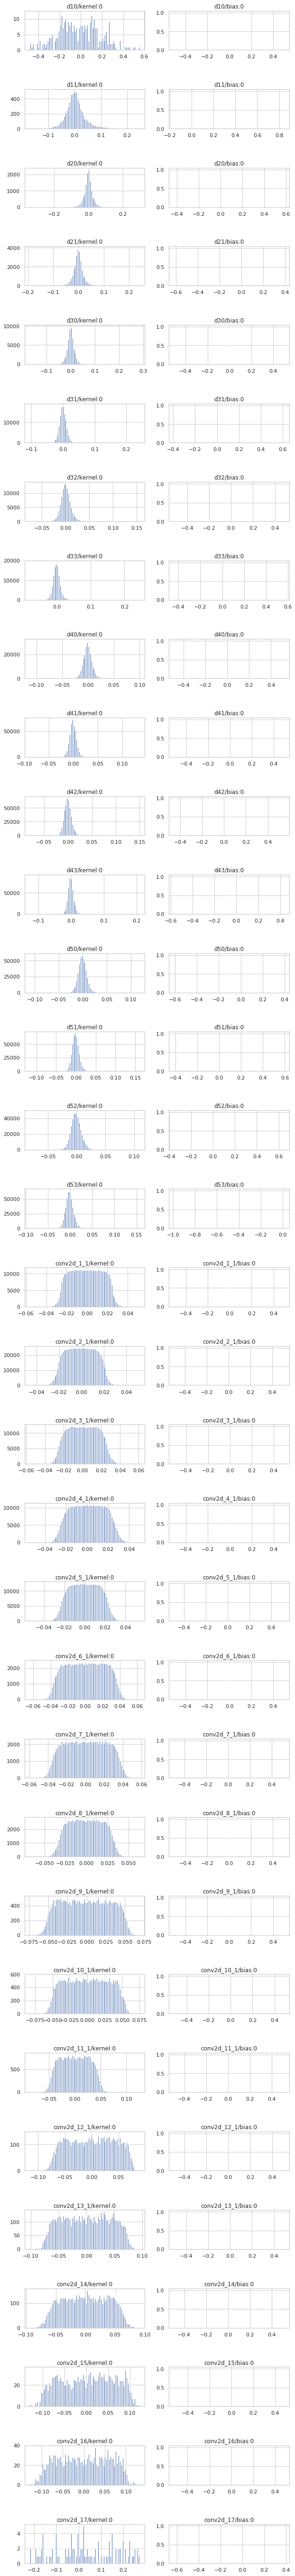

In [34]:
all_weights = []
all_names = []

# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.layers
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 150)
        if "bias" not in tensor.name:
            all_weights.append(weight[w].flatten())
            all_names.append(tensor.name)

In [35]:
df = pd.DataFrame(columns=['layer_name', 'weights_values'])
for n, w in zip(all_names,all_weights):
    if len(w) > 1:
        tmp = pd.DataFrame({"layer_name":[n for i in range(len(w.flatten()))], 
                            "weights_values":w.flatten()}) 
        df = df.append(tmp)

In [19]:
df.sample(3)

,layer_name,weights_values
156268,block4_conv4/kernel:0,0.003619
596215,block5_conv1/kernel:0,-0.003847
1999118,conv2d_2/kernel:0,-0.003802


In [20]:
df.loc[df['layer_name'] == "conv2d_1/kernel:0"]["weights_values"].values

array([-0.01122843, -0.0186998 , -0.01144505, ..., -0.01074998,
       -0.01685954,  0.00392004], dtype=float32)

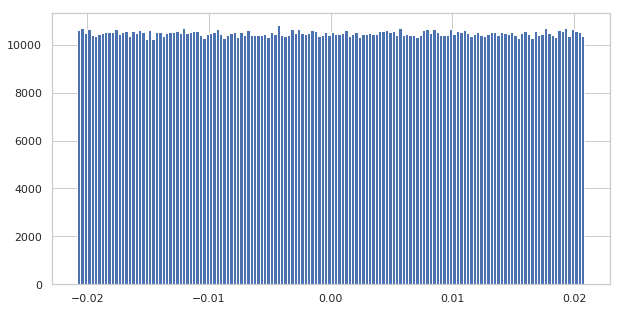

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = ax.hist(df.loc[df['layer_name'] == "conv2d_1/kernel:0"]["weights_values"].values, 150)

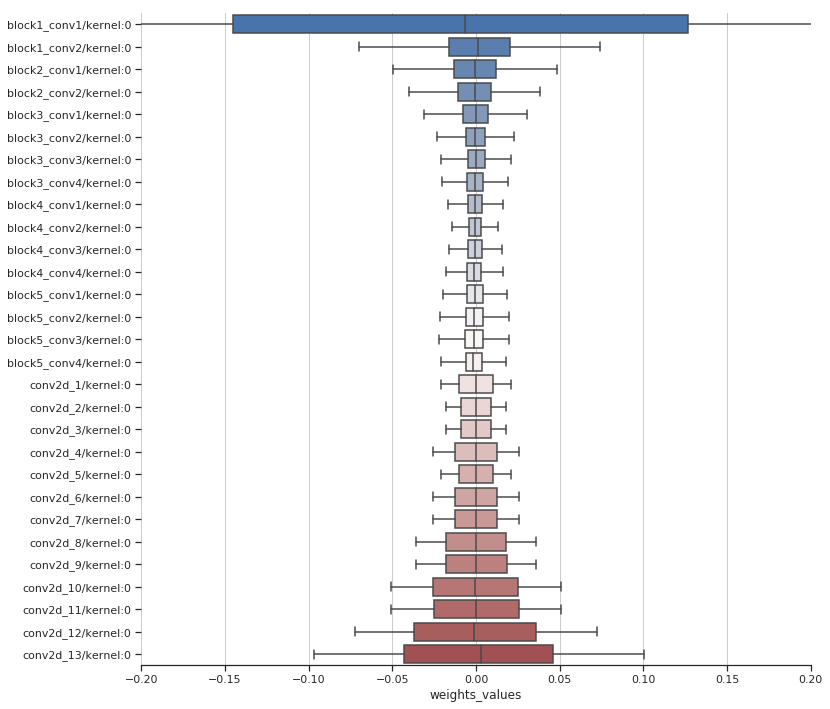

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 12))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="weights_values", y="layer_name", data=df, palette="vlag", fliersize=0, notch=False)

# Add in points to show each observation
#sns.swarmplot(x="weights_values", y="layer_name", data=tmp_df,
#              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlim=(-0.2, 0.2))
sns.despine(trim=True, left=True)

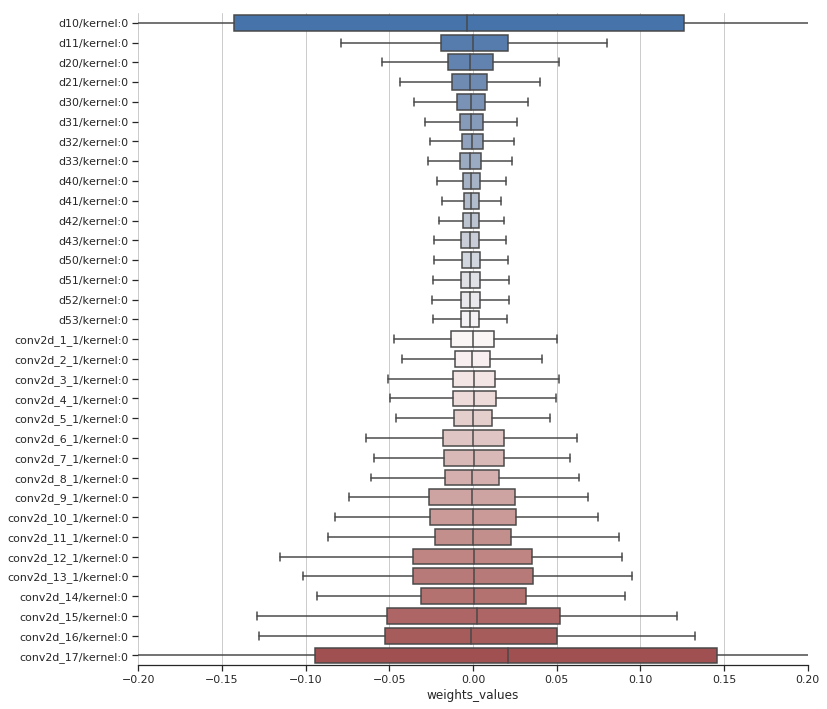

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 12))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="weights_values", y="layer_name", data=df, palette="vlag", fliersize=0, notch=False)

# Add in points to show each observation
#sns.swarmplot(x="weights_values", y="layer_name", data=tmp_df,
#              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlim=(-0.2, 0.2))
sns.despine(trim=True, left=True)

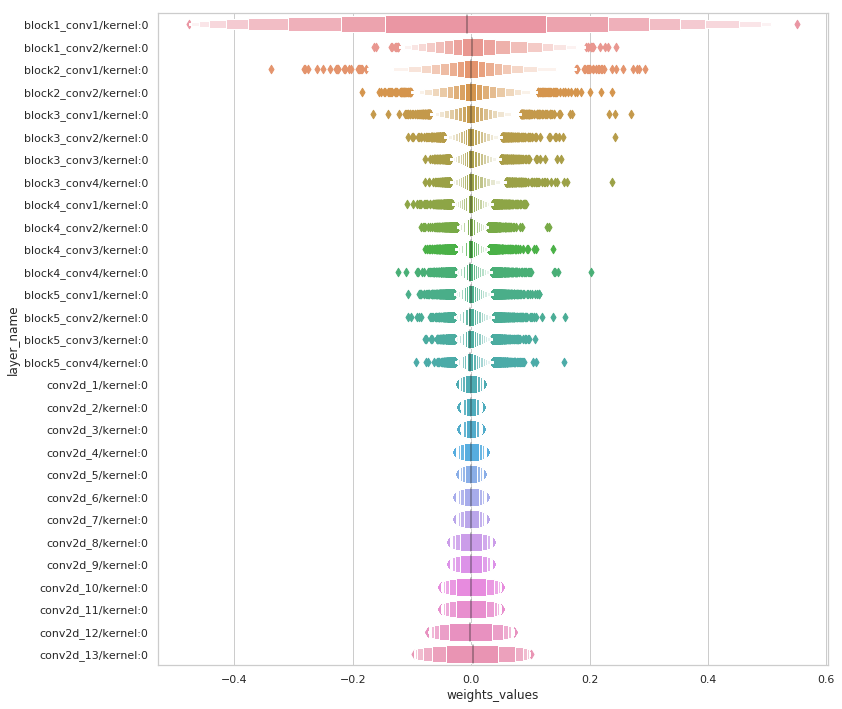

In [25]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))

sns.boxenplot(x="weights_values", y="layer_name",
              scale="linear", data=df)

/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


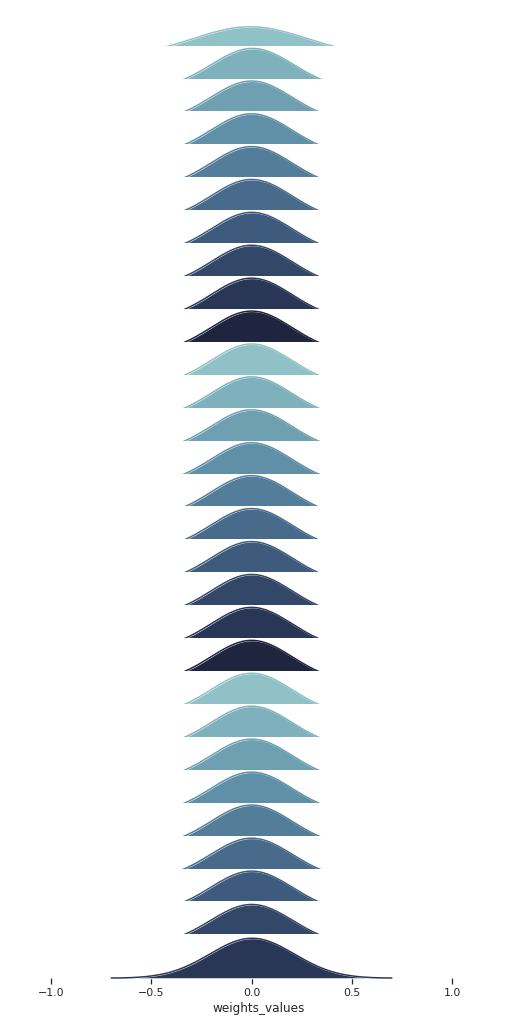

In [11]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="layer_name", hue="layer_name", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "weights_values", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g.map(sns.kdeplot, "weights_values", clip_on=False, color="w", lw=2, bw=.2)
#g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)